In [79]:
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import category_encoders as ce
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
insurance = pd.read_csv(os.path.abspath(os.getcwd() + os.sep + os.pardir)  + '\\data\\insurance.csv')
insurance.head()
insurance.dtypes

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
insurance.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [5]:
insurance["children"].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

In [6]:
#check for missing values
insurance.isnull().sum().sort_index(ascending=False)

smoker      0
sex         0
region      0
children    0
charges     0
bmi         0
age         0
dtype: int64

<Axes: xlabel='children', ylabel='charges'>

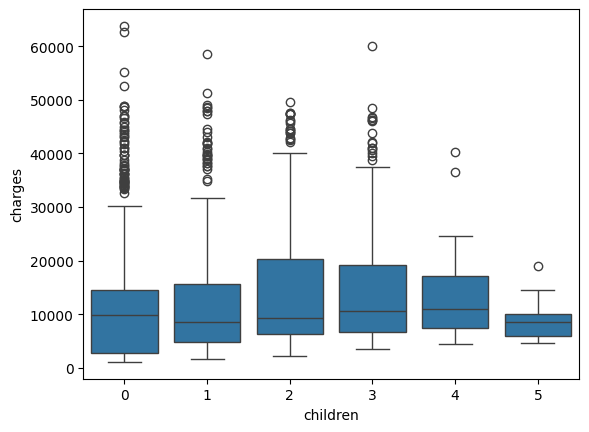

In [7]:
#check for outliers
sns.boxplot(x="children", y="charges", data=insurance)

<Axes: xlabel='smoker', ylabel='charges'>

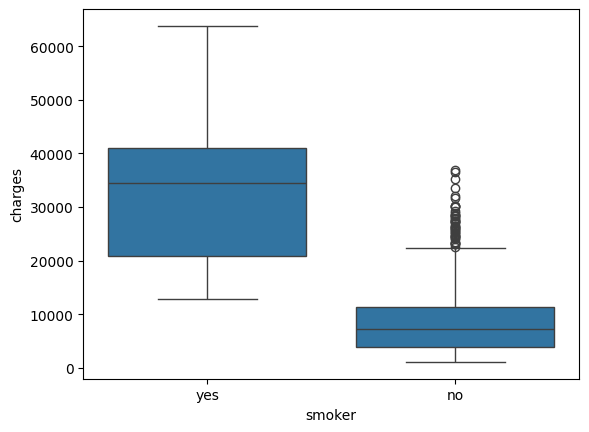

In [8]:
sns.boxplot(x="smoker", y="charges", data=insurance)

<Axes: xlabel='region', ylabel='charges'>

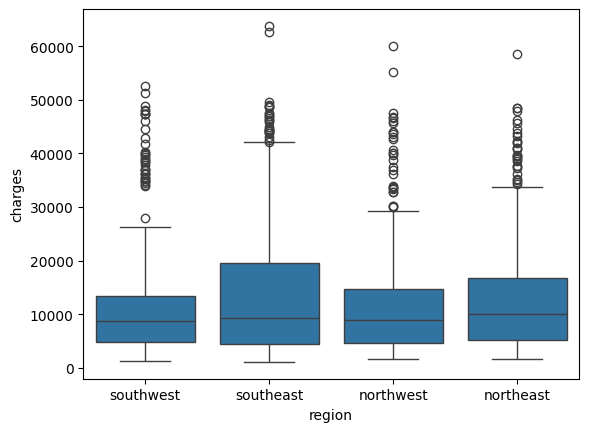

In [9]:
sns.boxplot(x="region", y="charges", data=insurance)

<Axes: xlabel='sex', ylabel='charges'>

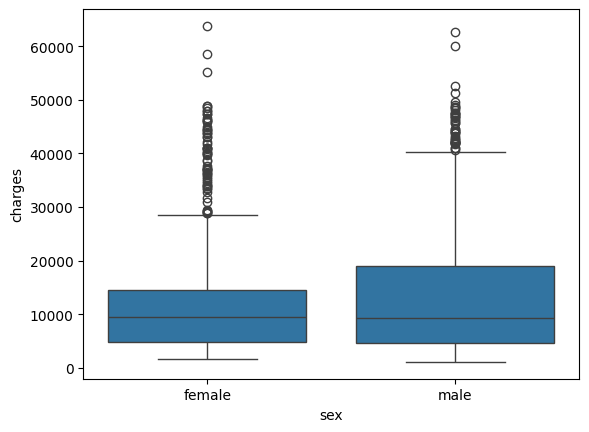

In [10]:
sns.boxplot(x="sex", y="charges", data=insurance)

age            Axes(0.125,0.53;0.352273x0.35)
bmi         Axes(0.547727,0.53;0.352273x0.35)
children       Axes(0.125,0.11;0.352273x0.35)
charges     Axes(0.547727,0.11;0.352273x0.35)
dtype: object

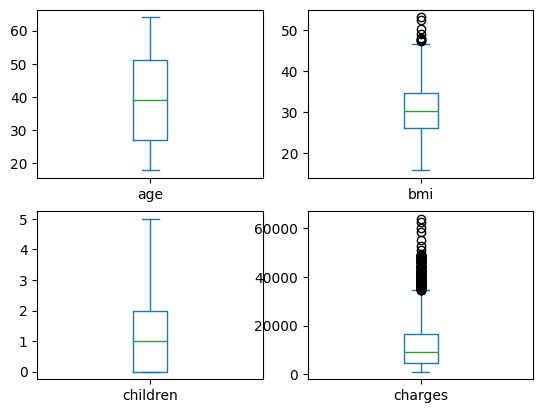

In [11]:
insurance.plot(kind='box', subplots=True, layout=(2,  2))

<Axes: xlabel='count', ylabel='smoker'>

<Axes: xlabel='count', ylabel='smoker'>

<Axes: xlabel='count', ylabel='smoker'>

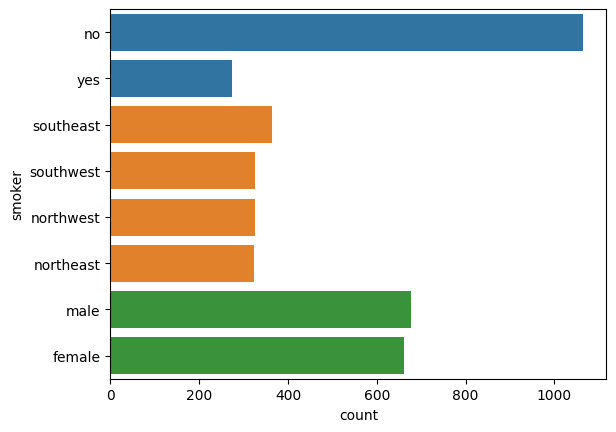

In [285]:
sns.countplot(insurance["smoker"], order=insurance['smoker'].value_counts().index)
sns.countplot(insurance["region"], order=insurance['region'].value_counts().index)
sns.countplot(insurance["sex"], order=insurance['sex'].value_counts().index)

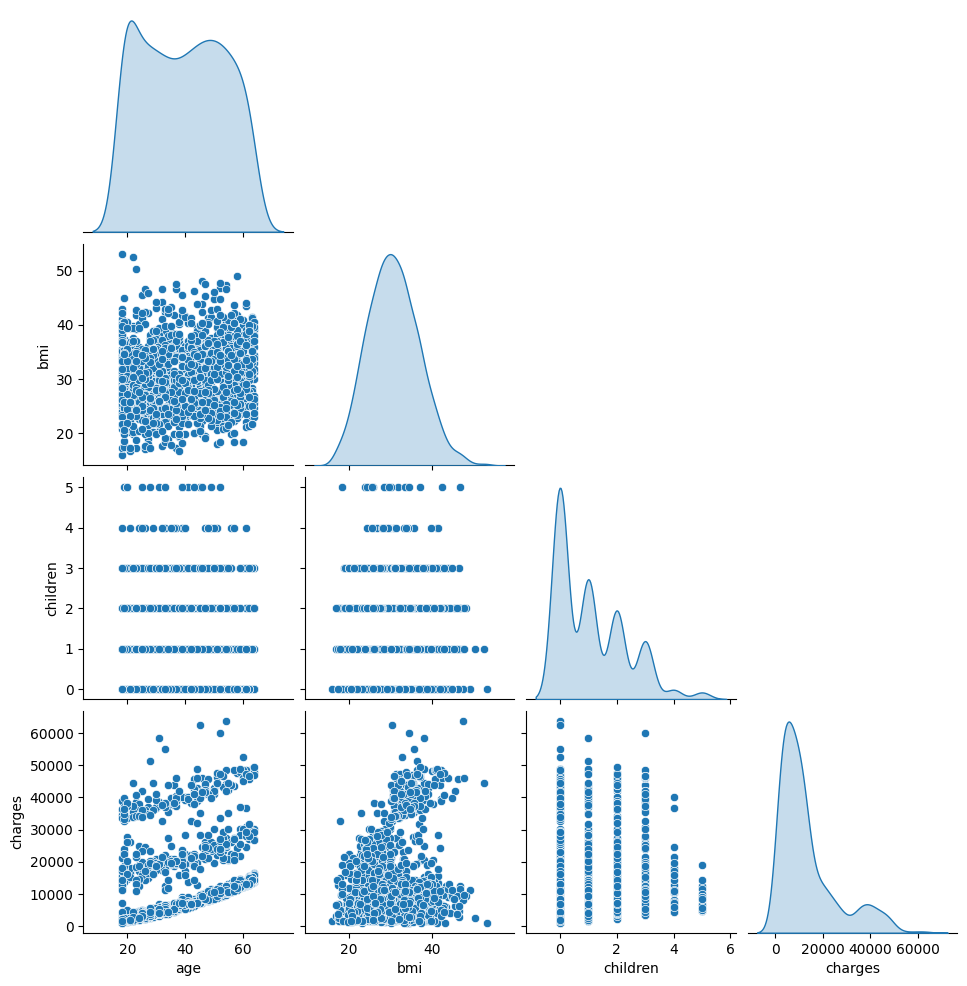

In [12]:
#check realtions between continuous variables
sns.pairplot(data=insurance, diag_kind='kde', corner=True)

<Figure size 1000x800 with 0 Axes>

<Axes: >

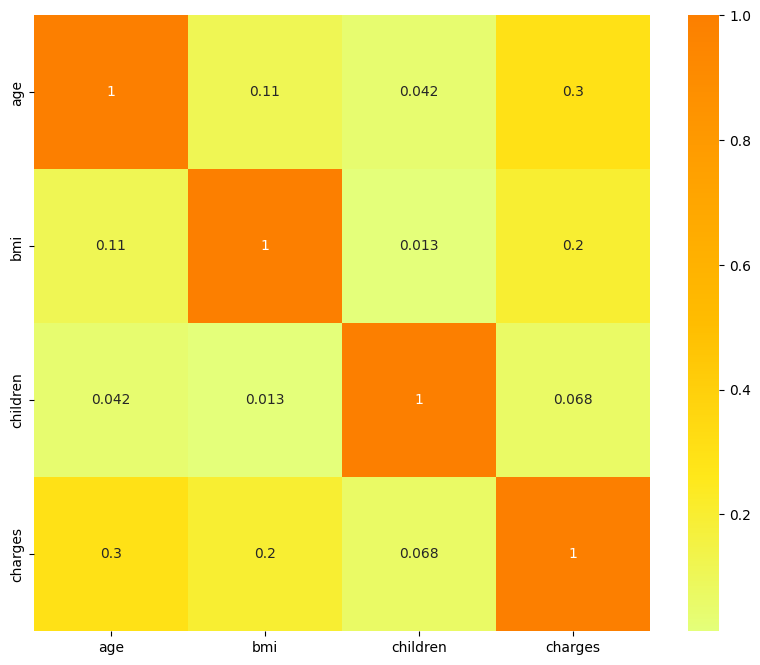

In [119]:
corr_matrix = insurance.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix ,cmap = 'Wistia', annot=True, square=True)
plt.show()

children    0.067998
bmi         0.198341
age         0.299008
charges     1.000000
Name: charges, dtype: float64

<Figure size 1000x800 with 0 Axes>

<Axes: ylabel='None'>

Text(0.5, 1.0, 'Correlation of Features with Charges')

Text(0.5, 0, 'Correlation Coefficient')

Text(0, 0.5, 'Features')

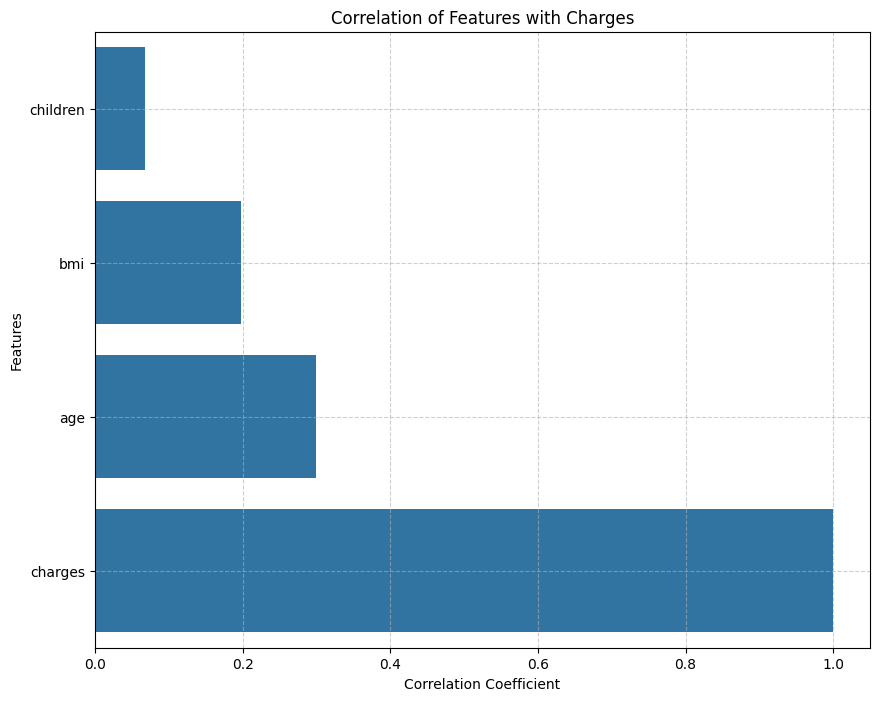

In [15]:
charges_corr = corr_matrix['charges'].sort_values()
charges_corr

plt.figure(figsize=(10, 8))
sns.barplot(x = charges_corr.values, y = charges_corr.index)
plt.title('Correlation of Features with Charges')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [38]:
#correlation between categorical variables
df_cat = pd.DataFrame(data = insurance.dtypes, columns = ['a']).reset_index()
cat_var = list(df_cat['index'].loc[df_cat['a'] == 'object'])
from itertools import product
cat_var_prod = list(product(cat_var,cat_var, repeat = 1))
cat_var_prod
df_cat = insurance[cat_var]
df_cat.head()

[('sex', 'sex'),
 ('sex', 'smoker'),
 ('sex', 'region'),
 ('smoker', 'sex'),
 ('smoker', 'smoker'),
 ('smoker', 'region'),
 ('region', 'sex'),
 ('region', 'smoker'),
 ('region', 'region')]

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


In [372]:
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(chi2_contingency(pd.crosstab(df_cat[i[0]], df_cat[i[1]])))[1]))

chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'p-val'])
chi_test_output.pivot(index='var1', columns='var2', values='p-val')

var2,region,sex,smoker
var1,,,
region,NaN,0.932892,0.061720
sex,0.932892,NaN,0.006548
smoker,0.061720,0.006548,NaN


In [373]:
#check correlation between cat variables
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


In [374]:
for i in cat_var_prod:
    if i[0] != i[1]:
        print(f'{i} - {cramers_v(insurance[i[0]], insurance[i[1]])}')

('sex', 'smoker') - 0.07433266042279539
('sex', 'region') - 0.018033700256745125
('smoker', 'sex') - 0.07433266042279539
('smoker', 'region') - 0.07408372915032314
('region', 'sex') - 0.018033700256745125
('region', 'smoker') - 0.07408372915032314


In [389]:
#Chi-Square tells us whether two categorical variables are related, but it doesn’t measure multicollinearity.
#Use VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.get_dummies(insurance[['sex', 'smoker', 'region']], drop_first=True)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            Feature       VIF
0          sex_male  0.002477
1        smoker_yes  0.004473
2  region_northwest  0.003725
3  region_southeast  0.003544
4  region_southwest  0.003739


In [388]:
#ANOVA to check correlation between target and categorical variables
#h0 = variables are independent
#hA = variables are correlated
from statsmodels.formula.api import ols
lm = ols('charges ~ sex', data = insurance).fit()
table = sm.stats.anova_lm(lm)
print("P-value for 1-way ANOVA test between sex and charges is: ",table.loc['sex','PR(>F)'])
lm1 = ols('charges ~ smoker', data = insurance).fit()
table1 = sm.stats.anova_lm(lm1)
print("P-value for 1-way ANOVA test between smoker and charges is: ",table1.loc['smoker','PR(>F)'])
lm2 = ols('charges ~ region', data = insurance).fit()
table2 = sm.stats.anova_lm(lm2)
print("P-value for 1-way ANOVA test between region and charges is: ",table2.loc['region','PR(>F)'])

P-value for 1-way ANOVA test between sex and charges is:  0.03613272100596256
P-value for 1-way ANOVA test between smoker and charges is:  8.271435842182967e-283
P-value for 1-way ANOVA test between region and charges is:  0.0308933560705201


In [356]:
#Feature selection
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(x_train[cat_X])
K_train_enc = oe.transform(x_train[cat_X])
kt = pd.DataFrame(K_train_enc, index=x_train[cat_X].index, columns=oe.get_feature_names_out())
kt
y_train= y_train.astype('int')

OrdinalEncoder()

,sex,smoker,region
348,0.0,0.0,2.0
306,0.0,0.0,3.0
620,1.0,0.0,3.0
1028,1.0,0.0,3.0
1176,0.0,1.0,1.0
...,...,...,...
715,1.0,0.0,3.0
905,0.0,0.0,0.0
1096,0.0,1.0,0.0
235,0.0,1.0,2.0


In [354]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(kt, y_train)
X_train_fs = fs.transform(kt)
X_train_fs

SelectKBest(k='all', score_func=<function chi2 at 0x0000027DB4703600>)

array([[0., 0., 2.],
       [0., 0., 3.],
       [1., 0., 3.],
       ...,
       [0., 1., 0.],
       [0., 1., 2.],
       [1., 0., 2.]], shape=(896, 3))

Feature 0: 432.084599
Feature 1: 704.208556
Feature 2: 707.720930


<BarContainer object of 3 artists>

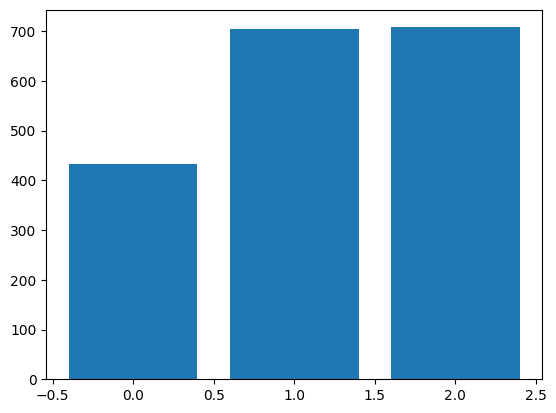

In [357]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [112]:
def fit_and_score(model, x, y):
    model.fit(x, y)
    score = model.score(x, y)
    print(f"Model score: {score}") # model accuracy
    y_pred = model.predict(x)
    return y_pred

In [76]:
def evaluate(model, x, y, y_fitted):
    print("MAE: %.2f" % mean_absolute_error(y, y_fitted))
    print("MSE: %.2f" % mean_squared_error(y, y_fitted))
    print("RMSE/Standard Error: %.2f" % root_mean_squared_error(y, y_fitted))
    rmse = np.sqrt(mean_squared_error(y, y_fitted))
    print("RMSE/Standard Error: %.2f" % rmse)
    print("Normalized RMSE:",  rmse / (y.max() - y.min()))
    print("R-Squared", model.score(x, y))

In [72]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(insurance.iloc[:,:-1], insurance.iloc[:,-1], test_size=0.33, random_state=1)
# summarize
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (896, 6) (896,)
Test (442, 6) (442,)


In [286]:
cat_X = x_train.select_dtypes(include='object').columns.to_list()

col_transformer = ColumnTransformer(transformers=[
    #("children_log", log_transformer, ["children"]),
    ("ohe", ce.OneHotEncoder(handle_unknown="ignore"), cat_X)
], remainder='passthrough')

p1 = Pipeline(steps=[
    ("ohe", col_transformer),
    ("lm", LinearRegression()),
])
p1

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lm', LinearRegression())])

In [287]:
#train evaluation
print("Train evaluation:")
y_pred = fit_and_score(p1, x_train, y_train)
evaluate(p1, x_train, y_train, y_pred)

#test evaluation
print("\nTest evaluation:")
y_pred_test = fit_and_score(p1, x_test, y_test)
evaluate(p1, x_test, y_test, y_pred_test)

Train evaluation:
Model score: 0.7553417867017556
MAE: 4171.59
MSE: 37048036.52
RMSE/Standard Error: 6086.71
RMSE/Standard Error: 6086.71
Normalized RMSE: 0.0971564294457434
R-Squared 0.7553417867017556

Test evaluation:
Model score: 0.74354402286202
MAE: 4142.63
MSE: 35019896.18
RMSE/Standard Error: 5917.76
RMSE/Standard Error: 5917.76
Normalized RMSE: 0.10048857011382417
R-Squared 0.74354402286202


In [288]:
p1[:-1].get_feature_names_out()

array(['ohe__sex_1', 'ohe__sex_2', 'ohe__smoker_1', 'ohe__smoker_2',
       'ohe__region_1', 'ohe__region_2', 'ohe__region_3', 'ohe__region_4',
       'remainder__age', 'remainder__bmi', 'remainder__children'],
      dtype=object)

<h3>Log Transform target

In [290]:
log_transformer = FunctionTransformer(np.log1p, validate=True, feature_names_out=lambda x: [f"log_{col}" for col in x])

# Transform target variable
y_train_transformed = log_transformer.fit_transform(pd.DataFrame(y_train))
y_test_transformed = log_transformer.transform(pd.DataFrame(y_test))

# Fit the pipeline on transformed target
p1.fit(x_train, y_train_transformed)

# Predict and apply inverse transformation
y_pred = np.expm1(p1.predict(x_train))  # Exponentiate back
y_pred_test = np.expm1(p1.predict(x_test))  # Exponentiate back

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lm', LinearRegression())])

In [291]:
p1.score(x_train, y_train_transformed)
print("\nTrain evaluation:")
evaluate(p1, x_train, y_train_transformed, y_pred)
print("\nTest evaluation:")
evaluate(p1, x_test, y_test_transformed, y_pred_test)

0.7623583618992027


Train evaluation:
MAE: 12978.82
MSE: 356735745.89
RMSE/Standard Error: 18887.45
RMSE/Standard Error: 18887.45
Normalized RMSE: 4675.789613342255
R-Squared 0.7623583618992027

Test evaluation:
MAE: 12751.01
MSE: 337961863.89
RMSE/Standard Error: 18383.74
RMSE/Standard Error: 18383.74
Normalized RMSE: 4630.333057355464
R-Squared 0.7778270993654832


<h3>Log transform Count column 'children'

In [268]:
num_x = ["children"]
col_transformer2 = ColumnTransformer(transformers=[
     ("children_log", log_transformer, num_x),
     ("ohe", ce.OneHotEncoder(handle_unknown="ignore", cols=cat_X), cat_X)
], remainder='passthrough')

In [292]:
p2 = Pipeline(steps=[
    ("col_trans2", col_transformer2),
    ("lm", LinearRegression()),  
])
p2

Pipeline(steps=[('col_trans2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('children_log',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x0000027DB79698A0>,
                                                                      func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['children']),
                                                 ('ohe',
                                                  OneHotEncoder(cols=['sex',
                                                                      'smoker',
                                                                      'region'],
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lm', LinearRegression())])

In [270]:
#train evaluation
print("Train evaluation:")
y_pred = fit_and_score(p2, x_train, y_train)
evaluate(p2, x_train, y_train, y_pred)

#test evaluation
print("\nTest evaluation:")
y_pred_test = fit_and_score(p2, x_test, y_test)
evaluate(p2, x_test, y_test, y_pred_test)

Train evaluation:
Model score: 0.7552066884386676
MAE: 4178.37
MSE: 37068494.14
RMSE/Standard Error: 6088.39
RMSE/Standard Error: 6088.39
Normalized RMSE: 0.0971832502363025
R-Squared 0.7552066884386676

Test evaluation:
Model score: 0.7446266952516807
MAE: 4141.78
MSE: 34872053.75
RMSE/Standard Error: 5905.26
RMSE/Standard Error: 5905.26
Normalized RMSE: 0.10027623100210885
R-Squared 0.7446266952516807


In [293]:
p3 = Pipeline(steps=[
   ("col_trans", col_transformer2)
])
p3

'''
ct = ColumnTransformer(transformers=[
    ("clog", log_transformer, ["children"]),   
], remainder='passthrough')
p1 = Pipeline(steps=[
    ("ohe", ce.OneHotEncoder(handle_unknown="ignore", handle_missing='ignore')),
    #("lm", LinearRegression()),
])
p3 = Pipeline(steps=[
   ("col_trans", ct),
    ("p1", p1)
])
'''

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('children_log',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x0000027DB79698A0>,
                                                                      func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['children']),
                                                 ('ohe',
                                                  OneHotEncoder(cols=['sex',
                                                                      'smoker',
                                                                      'region'],
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])]))])

'\nct = ColumnTransformer(transformers=[\n    ("clog", log_transformer, ["children"]),   \n], remainder=\'passthrough\')\np1 = Pipeline(steps=[\n    ("ohe", ce.OneHotEncoder(handle_unknown="ignore", handle_missing=\'ignore\')),\n    #("lm", LinearRegression()),\n])\np3 = Pipeline(steps=[\n   ("col_trans", ct),\n    ("p1", p1)\n])\n'

In [320]:
feature_names = []

# Handle FunctionTransformer (it doesn't provide get_feature_names_out)
if isinstance(log_transformer, FunctionTransformer):
    feature_names.extend([f"log_{col}" for col in num_x])  # Manually set names for log features

ohe = p3.named_steps["col_trans"].named_transformers_["ohe"]
if hasattr(ohe, "get_feature_names_out"):
    feature_names.extend(ohe.get_feature_names_out(cat_X))

remaining_features = [col for col in x_train.columns if col not in num_x + cat_X]
feature_names.extend(remaining_features)
feature_names

['log_children',
 'sex_1',
 'sex_2',
 'smoker_1',
 'smoker_2',
 'region_1',
 'region_2',
 'region_3',
 'region_4',
 'age',
 'bmi']

In [322]:
# Transform X_train using the pipeline
X_train_transformed = p3.fit_transform(x_train)

# Convert NumPy array back to DataFrame & preserve index
X_train_transformed = pd.DataFrame(X_train_transformed, index=x_train.index, columns=feature_names)

# Add an intercept column for statsmodels
X_train_transformed = sm.add_constant(X_train_transformed)

# Fit statsmodels OLS model
ols_model = sm.OLS(y_train, X_train_transformed).fit()

# Print summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     342.1
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          5.45e-265
Time:                        16:14:52   Log-Likelihood:                -9079.2
No. Observations:                 896   AIC:                         1.818e+04
Df Residuals:                     887   BIC:                         1.822e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          140.8865    535.814      0.263   

In [361]:
# Transform test data
X_test_transformed = p3.transform(x_test)
X_test_transformed = pd.DataFrame(X_test_transformed, index=x_test.index, columns=feature_names)
X_test_transformed = sm.add_constant(X_test_transformed)

# Predict using the fitted model
y_pred_ols = ols_model.predict(X_test_transformed)
y_pred_ols

559      4415.507469
1087    12925.270932
1020    12581.871305
460     13150.663506
802       751.710819
            ...     
226      6939.075050
418     17054.411497
1057     9566.563685
180     12253.933444
191      5556.007985
Length: 442, dtype: float64

In [363]:
print("Train evaluation:")
y_fitted_ols = ols_model.fittedvalues
print("MSE: %.2f" % mean_squared_error(y_train, y_fitted_ols))
print("RMSE/Standard Error: %.2f" % root_mean_squared_error(y_train, y_fitted_ols))
print("MAE: %.2f" % mean_absolute_error(y_train, y_fitted_ols))

print("\nTest evaluation:")
print("MSE: %.2f" % mean_squared_error(y_test, y_pred_ols))
print("RMSE/Standard Error: %.2f" % root_mean_squared_error(y_test, y_pred_ols))
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred_ols))

Train evaluation:
MSE: 37068508.36
RMSE/Standard Error: 6088.39
MAE: 4178.51

Test evaluation:
MSE: 35524610.78
RMSE/Standard Error: 5960.25
MAE: 4080.49
